## Findinf similar compunds in unknown substances

Code taken and addapted from Florian Huber's Jupyter notebooks to perform an experiment of Library matching
https://github.com/iomega/spec2vec_gnps_data_analysis/blob/master/notebooks/iomega-9-unknown-compound-search-only-annotated-spectra.ipynb

In [1]:
import os
import sys
import gensim
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

ROOT = os.path.dirname(os.getcwd())

sys.path.insert(0, ROOT)

In [2]:
from custom_functions.spectra_functions import get_data_folder_path

path = get_data_folder_path()

## Import Mona file spectra
* 14847 spectra
* 14359 with peaks >= 10

In [3]:
from matchms.importing import load_from_msp

spectrums_file = os.path.join(path, "MoNA-export-GC-MS.msp")
spectrums = [s for s in load_from_msp(spectrums_file)]

print("Number of spectra:", len(spectrums))

Number of spectra: 14847


### Post-process data
Run matchms based processing pipeline:

* Normalize peaks
* remove spectra with <10 peaks
* reduce number of peaks to reduce noise and create more homogeneous document sizes
* remove low intensity peaks

For this filterring we cannot add neutral losses, since GC/MS does not have parent mass

In [4]:
from matchms.filtering import normalize_intensities
from matchms.filtering import require_minimum_number_of_peaks
from matchms.filtering import select_by_mz
from matchms.filtering import select_by_relative_intensity
from matchms.filtering import reduce_to_number_of_peaks

def post_process_s2v(s):
    s = normalize_intensities(s)
    s = select_by_mz(s, mz_from=0, mz_to=1000)
    s = require_minimum_number_of_peaks(s, n_required=10)
    s = reduce_to_number_of_peaks(s, n_required=10, ratio_desired=0.5)
    if s is None:
        return None
    s_remove_low_peaks = select_by_relative_intensity(s, intensity_from=0.001)
    if len(s_remove_low_peaks.peaks) >= 10:
        s = s_remove_low_peaks
        
    # s = add_losses(s, loss_mz_from=5.0, loss_mz_to=200.0)
    return s

# apply post processing steps to the data
spectrums_s2v = [post_process_s2v(s) for s in spectrums]

# omit spectrums that didn't qualify for analysis
spectrums_s2v = [s for s in spectrums_s2v if s is not None]

In [5]:
print("After processing {} spectra remain.".format(len(spectrums_s2v)))

After processing 14359 spectra remain.


## Inspect annotations

In [6]:
Inchikeys = []
for spec in spectrums_s2v:
    Inchikeys.append(spec.get("inchikey"))
    
print("Found {} spectra with Inchikey".format(len(Inchikeys)),
     "(out of {}).".format(len(spectrums_s2v)))

Found 14359 spectra with Inchikey (out of 14359).


In [7]:
spectrum_idx_no_inchikey = [i for i, x in enumerate(Inchikeys) if not x]
print("Spectra without inchikey:", len(spectrum_idx_no_inchikey))

Spectra without inchikey: 0


In [8]:
Inchikeys[:10]

['ALRLPDGCPYIVHP-UHFFFAOYSA-N',
 'UFBJCMHMOXMLKC-UHFFFAOYSA-N',
 'WDNBURPWRNALGP-UHFFFAOYSA-N',
 'RANCECPPZPIPNO-UHFFFAOYSA-N',
 'HOLHYSJJBXSLMV-UHFFFAOYSA-N',
 'UMPSXRYVXUPCOS-UHFFFAOYSA-N',
 'HFZWRUODUSTPEG-UHFFFAOYSA-N',
 'VPOMSPZBQMDLTM-UHFFFAOYSA-N',
 'LHJGJYXLEPZJPM-UHFFFAOYSA-N',
 'LINPIYWFGCPVIE-UHFFFAOYSA-N']

In [9]:
inchikeys_pd = pd.Series([x for x in Inchikeys])
inchikeys_pd.str[:14].value_counts()[:10]

WQZGKKKJIJFFOK    29
GUBGYTABKSRVRQ    21
DCXYFEDJOCDNAF    18
DLYVTEULDNMQAR    16
GZCGUPFRVQAUEE    16
MBWXNTAXLNYFJB    16
BJHIKXHVCXFQLS    16
ZDXPYRJPNDTMRX    15
FBPFZTCFMRRESA    15
KIDHWZJUCRJVML    14
dtype: int64

In [10]:
inchikeys_notempty = inchikeys_pd[[i for i,x in enumerate(inchikeys_pd) if x]]
inchikeys_notempty.head()

0    ALRLPDGCPYIVHP-UHFFFAOYSA-N
1    UFBJCMHMOXMLKC-UHFFFAOYSA-N
2    WDNBURPWRNALGP-UHFFFAOYSA-N
3    RANCECPPZPIPNO-UHFFFAOYSA-N
4    HOLHYSJJBXSLMV-UHFFFAOYSA-N
dtype: object

Text(0.5, 1.0, 'Histogram of spectra per unique InchiKey (first 14 characters)')

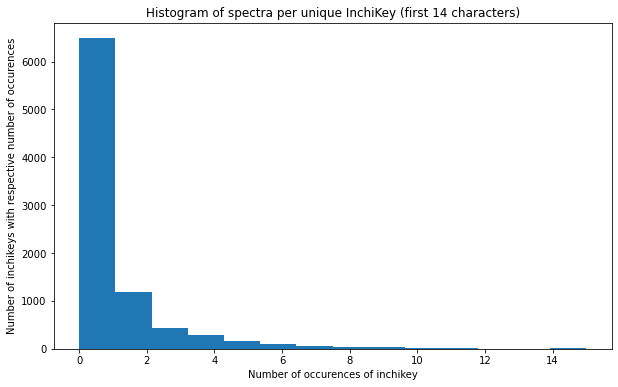

In [11]:
plt.figure(figsize=(10,6))
plt.hist(inchikeys_notempty.str[:14].value_counts(), np.linspace(0, 15, 15))
plt.xlabel('Number of occurences of inchikey')
plt.ylabel('Number of inchikeys with respective number of occurences')
plt.title("Histogram of spectra per unique InchiKey (first 14 characters)")

## Select query spectra (which will be removed from library)
* Randomly select 300 InchiKeys
* Select all spectra with those InchiKeys

In [12]:
unique_inchikeys = inchikeys_notempty.str[:14].unique()
print("Found {} unique InchiKeys in the dataset (counting first 14 characters only)".format(unique_inchikeys.shape[0]))

Found 8843 unique InchiKeys in the dataset (counting first 14 characters only)


In [13]:
np.random.seed(0) # to make it reproducible
selected_inchikeys = np.random.choice(unique_inchikeys, 300, replace=False)
selected_inchikeys[:25]

array(['IOZLPDWMWQMTRB', 'KMWQDYIEBWJWIC', 'PDUSWJORWQPNRP',
       'YSCKLAUVHVINBE', 'WTARULDDTDQWMU', 'LOGIKTHBNCEEST',
       'LRDUEXWYKQITLS', 'POQLVOYRGNFGRM', 'CBUMHWYKQJKMTE',
       'ZVAPIIDBWWULJN', 'XGXZBLXZWJRBCZ', 'RZXMPPFPUUCRFN',
       'GALQLODNTKQGFE', 'MVAWJSIDNICKHF', 'YTDZUPBPWJAQDV',
       'YGYNBBAUIYTWBF', 'BTCSSZJGUNDROE', 'QWUWMCYKGHVNAV',
       'CKSRFHWWBKRUKA', 'JWAZRIHNYRIHIV', 'ARSLOAKOWGOSEX',
       'IDHRHHLXBFGLSE', 'SYIOXNGUUYGIIF', 'YVFLMEGQPCRTTO',
       'ALVPFGSHPUPROW'], dtype=object)

In [14]:
selected_spectra = []

for inchikey in selected_inchikeys:
    matches = inchikeys_notempty[inchikeys_notempty.str[:14] == inchikey].index.values
    selected_spectra.extend(matches)

print(len(selected_spectra), "spectra were found with Inchikeys from selected_inchikeys list.")

502 spectra were found with Inchikeys from selected_inchikeys list.


### Check if that worked

In [15]:
inchikey = selected_inchikeys[11]
print(inchikey)

matches_test = inchikeys_pd[inchikeys_pd.str[:14] == inchikey].index.values

for idx in matches_test:
    print(spectrums_s2v[idx].get("inchikey")[:14])

RZXMPPFPUUCRFN
RZXMPPFPUUCRFN
RZXMPPFPUUCRFN
RZXMPPFPUUCRFN


In [16]:
print(selected_spectra[:25])


[579, 768, 276, 6837, 3113, 3384, 219, 5091, 6355, 6769, 9921, 11004, 7734, 7960, 7120, 7131, 1597, 1169, 2078, 8650, 51, 12789, 12790, 13932, 13933]


Text(0.5, 1.0, 'Histogram of selected spectra\nper unique InchiKey (first 14 characters)')

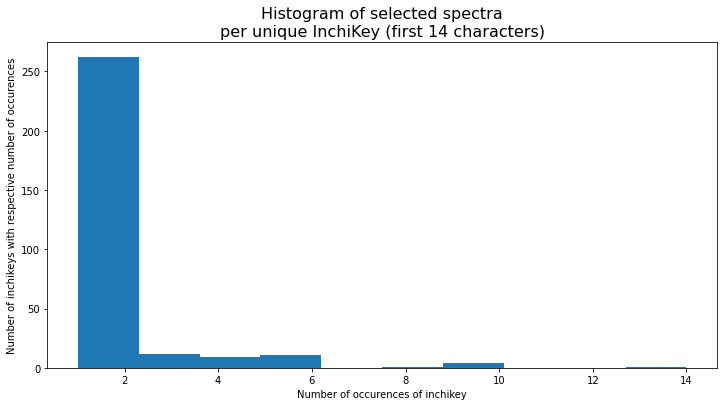

In [17]:
plt.figure(figsize=(12,6))
plt.hist(inchikeys_pd.str[:14][selected_spectra].value_counts())
plt.xlabel('Number of occurences of inchikey')
plt.ylabel('Number of inchikeys with respective number of occurences')
plt.title("Histogram of selected spectra\nper unique InchiKey (first 14 characters)", fontsize=16)

In [18]:
selected_inchikey_counts = inchikeys_pd.str[:14][selected_spectra].value_counts()
print("Mean number of spectra per Inchikey:", np.mean(selected_inchikey_counts))
print("Median number of spectra per Inchikey:", np.median(selected_inchikey_counts))
print("Maximum number of spectra per Inchikey:", np.max(selected_inchikey_counts))

Mean number of spectra per Inchikey: 1.6733333333333333
Median number of spectra per Inchikey: 1.0
Maximum number of spectra per Inchikey: 14


### Train new model on AllPositive dataset WITHOUT selected spectra and WITHOUT non-annotated spectra (to make sure none is included that would belong to a removed Inchikey)
* Create a SpectrumDocument for each spectrum:
* documents_library containing only spectra without the selected Inchikeys
* documents_query containing only spectra with the selected Inchikeys
* Train model on library documents (Careful: Not allowed to contain any spectra with selected query Inchikeys!)

In [19]:
from spec2vec import Spec2VecParallel
from spec2vec import SpectrumDocument

In [20]:
documents_library = []
for i, spec in enumerate(spectrums_s2v):
    if i not in selected_spectra and i not in spectrum_idx_no_inchikey:
        documents_library.append(SpectrumDocument(spec, n_decimals=2))

#### Check if indeed all library spectra have inchikey

In [21]:
library_inchikeys = []
for doc in documents_library:
    library_inchikeys.append(doc._obj.get("inchikey"))

print("Found {} spectra with Inchikey".format(len([x for x in library_inchikeys if x])),
     "(out of {} library spectra).".format(len(documents_library)))

Found 13857 spectra with Inchikey (out of 13857 library spectra).


In [23]:

documents_query = [SpectrumDocument(spectrums_s2v[i], n_decimals=2) for i in selected_spectra]


In [24]:

# Check dimensions
len(spectrums_s2v), len(documents_library), len(documents_query)

(14359, 13857, 502)

In [25]:
from spec2vec.model_building import train_new_word2vec_model

path_models = os.path.join(path, "trained_models")
model_file = os.path.join(path_models, "spec2vec_unknown_matching_all_annotated.model")

iterations = [1, 3, 5, 10, 15, 20]

# Train model with default parameters
model = train_new_word2vec_model(documents_library, iterations, model_file)

  Epoch 1 of 20.Change in loss after epoch 1: 311368.53125
Saving model with name: /Users/efra/../../Volumes/easystore/spec2vec_gcms_data_analysis/data/trained_models/spec2vec_unknown_matching_all_annotated_iter_1.model
  Epoch 2 of 20.Change in loss after epoch 2: 285922.71875
  Epoch 3 of 20.Change in loss after epoch 3: 268955.5
Saving model with name: /Users/efra/../../Volumes/easystore/spec2vec_gcms_data_analysis/data/trained_models/spec2vec_unknown_matching_all_annotated_iter_3.model
  Epoch 4 of 20.Change in loss after epoch 4: 255735.75
  Epoch 5 of 20.Change in loss after epoch 5: 244978.875
Saving model with name: /Users/efra/../../Volumes/easystore/spec2vec_gcms_data_analysis/data/trained_models/spec2vec_unknown_matching_all_annotated_iter_5.model
  Epoch 6 of 20.Change in loss after epoch 6: 241745.875
  Epoch 7 of 20.Change in loss after epoch 7: 240386.25
  Epoch 8 of 20.Change in loss after epoch 8: 234564.625
  Epoch 9 of 20.Change in loss after epoch 9: 223261.375
  Ep

### Actual library matching
* Import library_matching function
* Load pre-trained model
* Generate query documents
* Query those documents against the library

In [26]:
sys.path.insert(0, os.path.join(ROOT, "custom_functions"))


In [27]:
from library_search import library_matching


### Load word2vec model

In [28]:
path_models = os.path.join(path, "trained_models")
model_file = os.path.join(path_models, "spec2vec_unknown_matching_all_annotated_iter_15.model")
model = gensim.models.Word2Vec.load(model_file)

### Correct a few (< 10) spectrums with missing precursor_mz

### Run Spec2Vec based library matching for 324 against 14035 spectra
* library_matching will return one pandas DataFrame for every query, which contains the selected best candidates, their IDs and scores.
* The word2vec model was trained on the library spectra and is now applied on the query spectra. This means that occationally some words (=peaks) will be unknown to the model. The missing weighted fraction will be reported during the library search. allowed_missing_percentage can be used to set the maximum allowed missing percentage.

In [29]:
import time

tstart = time.time()
found_matches = library_matching(documents_query, documents_library,
                                 model,
                                 presearch_based_on=["spec2vec-top10"],
                                 ignore_non_annotated=True,
                                 include_scores=["spec2vec", "cosine"],
                                 intensity_weighting_power=0.5,
                                 allowed_missing_percentage=24.0, # 24 was the minimum to run the code
                                 cosine_tol=0.005)
tend = time.time()
print("Execution time was {:.2f}s (library search of {} query spectra against {} library spectra).".format((tend-tstart),
                                                                                                       len(documents_query),
                                                                                                       len(documents_library)))

Pre-selection includes spec2vec top 10.
Found 2 word(s) missing in the model. Weighted fraction not covered is 2.08%.
Found 19 word(s) missing in the model. Weighted fraction not covered is 23.09%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 4.88%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.54%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.54%.
Execution time was 12.16s (library search of 502 query spectra against 13857 library spectra).


### Search only based on Spec2Vec (no extra parent mass searches)

In [30]:

tstart = time.time()
found_matches_s2vonly = library_matching(documents_query, documents_library,
                                 model,
                                 presearch_based_on=["spec2vec-top10"],
                                 include_scores=["spec2vec"], # leave out modcosine and cosine here
                                 ignore_non_annotated=True,
                                 intensity_weighting_power=0.5,
                                 allowed_missing_percentage=24.0,
                                 cosine_tol=0.005)
tend = time.time()
print("Execution time was {:.2f}s (library search of {} query spectra against {} library spectra).".format((tend-tstart),
                                                                                                       len(documents_query),
                                                                                                       len(documents_library)))

Pre-selection includes spec2vec top 10.
Found 2 word(s) missing in the model. Weighted fraction not covered is 2.08%.
Found 19 word(s) missing in the model. Weighted fraction not covered is 23.09%.
Found 2 word(s) missing in the model. Weighted fraction not covered is 4.88%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.54%.
Found 1 word(s) missing in the model. Weighted fraction not covered is 0.54%.
Execution time was 12.36s (library search of 502 query spectra against 13857 library spectra).


In [31]:
# Check number of queries done
len(found_matches), len(found_matches_s2vonly)

(502, 502)

### Inspect tables with found matches

In [32]:
found_matches[104].sort_values(by=["s2v_score"], ascending=False)


,cosine_score,cosine_matches,s2v_score
6050,0.923259,26,0.895805
5895,0.891127,20,0.810556
245,0.863805,22,0.804084
5903,0.921043,26,0.798236
5906,0.929208,28,0.793295
4886,0.876438,19,0.776130
4887,0.876438,19,0.776130
5899,0.901181,21,0.773982
6966,0.825521,32,0.763449
1118,0.642812,29,0.759010


## Evaluate results
### Collect all top-10 matches based on Spec2Vec similarity
* Select top-10 spec2vec score matches for every query
* Get fingerprint-based reference scores for those suggested matches

Define get_mol_fingerprints function.

In [33]:
from matchms.utils import derive_fingerprint_from_inchi
from matchms.utils import derive_fingerprint_from_smiles

def get_mol_fingerprints(spectrums, fingerprint_type="daylight", nbits=2048):
    """Return molecular finterprints.
    """
    def _get_fingerprint_from_spectrum(spectrum):
        # First try to get fingerprint from smiles
        if spectrum is None: 
            return None
        if spectrum.get("smiles", None):
            fingerprint = derive_fingerprint_from_smiles(spectrum.get("smiles"),
                                                         fingerprint_type, nbits)
            if isinstance(fingerprint, np.ndarray) and fingerprint.sum() > 0:
                return fingerprint

        # Second try to get fingerprint from inchi
        if spectrum.get("inchi", None):
            fingerprint = derive_fingerprint_from_inchi(spectrum.get("inchi"),
                                                        fingerprint_type, nbits)
            if isinstance(fingerprint, np.ndarray) and fingerprint.sum() > 0:
                return fingerprint  
        
    fingerprints = []
    for spec in spectrums:
        fingerprint = _get_fingerprint_from_spectrum(spec)
        fingerprints.append(fingerprint)
    
    return fingerprints

In [34]:
from matchms.similarity.vector_similarity_functions import jaccard_similarity_matrix

mol_sim_matches = []
list_sv2 = []
list_cos = []

for ID in range(len(documents_query)):
    idx = found_matches[ID].sort_values(by=["s2v_score"], ascending=False).index.tolist()[:10]
    
    if len(idx) > 0:
        fingerprint_query = get_mol_fingerprints([documents_query[ID]._obj], 
                                                     fingerprint_type="daylight", #morgan3", 
                                                     nbits=2048)
        fingerprint_matches = get_mol_fingerprints([documents_library[i]._obj for i in idx], 
                                                     fingerprint_type="daylight", #morgan3",  
                                                     nbits=2048)

        # Calculate similarities
        if fingerprint_query[0] is None:
            print("No fingerprint generated for query spectrum {}".format(ID))
        else:
            if np.sum([1 for x in fingerprint_matches if x is None]) > 0:
                print("Found {} not generated fingerprints in matches".format(np.sum([1 for x in fingerprint_matches if x is None])))
            exclude_empty_fps = [i for i, x in enumerate(fingerprint_matches) if x is not None]
            if len(fingerprint_matches) > 0 and len(fingerprint_query) > 0:
                Mtest = jaccard_similarity_matrix(np.asarray(fingerprint_query),
                                                   np.asarray([fingerprint_matches[i] for i in exclude_empty_fps]))
                mol_sim_matches.append(Mtest)
            else:
                mol_sim_matches.append(None)

            list_sv2.append(found_matches[ID].loc[[idx[i] for i in exclude_empty_fps]]['s2v_score'].values.tolist())
            list_cos.append(found_matches[ID].loc[[idx[i] for i in exclude_empty_fps]]['cosine_score'].values.tolist())

RDKit ERROR: [13:00:22] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7
RDKit ERROR: 
RDKit ERROR: [13:00:22] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7
RDKit ERROR: 
RDKit ERROR: [13:00:23] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 10 11 13
RDKit ERROR: 
RDKit ERROR: [13:00:23] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 10 11 13
RDKit ERROR: 
RDKit ERROR: [13:00:23] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 10 11 13
RDKit ERROR: 
RDKit ERROR: [13:00:23] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 10 11 13
RDKit ERROR: 
RDKit ERROR: [13:00:23] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 9 10 12
RDKit ERROR: 
RDKit ERROR: [13:00:23] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [13:00:24] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 9 10 12
RDKit ERROR: 
RDKit ERROR: [13:00:24] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 9 10 12
RDKit ERROR: 
RDKit ERROR: [13:00:24] Can'

RDKit ERROR: [13:00:48] Can't kekulize mol.  Unkekulized atoms: 6 7 9 10 11 12 13 14 15
RDKit ERROR: 
RDKit ERROR: [13:00:48] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14 15 16
RDKit ERROR: 
RDKit ERROR: [13:00:48] Can't kekulize mol.  Unkekulized atoms: 11 16 17 18 19 20 21 22 23
RDKit ERROR: 
RDKit ERROR: [13:00:48] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14 15 16
RDKit ERROR: 
RDKit ERROR: [13:00:49] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9 10 11 12 13
RDKit ERROR: 
RDKit ERROR: [13:00:49] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [13:00:49] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [13:00:49] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 15
RDKit ERROR: 
RDKit ERROR: [13:00:49] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 15
RDKit ERROR: 
RDKit ERROR: [13:00:49] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 10 11 13


#### Define a histogram plotting function

In [35]:
def histogram_found_matches(matches,
                            n_bins,
                            method = "ideal_pick",
                            sort_by_lst = None):
    """ Create histogram and plot it.
    """
    bins_lst = np.linspace(0,1,n_bins+1) 
    plt.style.use('default') #('ggplot')
    plt.figure(figsize=(8,7))
    
    nums = len(matches)
    if method == "ideal_pick":
        # Chose best pick from condidate suggestions
        #hist, bin_edges = np.histogram(np.max(matches, axis=2), bins_lst)
        pick = []
        for i in range(nums):
            pick += [np.array(matches[i]).argmax()]
        hist, bin_edges = np.histogram(np.array([matches[i][0][pick[i]] for i in range(nums)]), bins_lst)
    elif method == 'argmax':
        if sort_by_lst is None:
            print("sort_by_lst list expected.")
        pick = []
        for i in range(nums):
            pick += [np.array(sort_by_lst[i]).argmax()]
        hist, bin_edges = np.histogram(np.array([matches[i][0][pick[i]] for i in range(nums)]), bins_lst)
    
    bar_width = 0.8 * 1/n_bins
    plt.bar(bin_edges[:-1], 100*hist/np.sum(hist), width = bar_width, color='none', edgecolor='gray', hatch="///", lw=2., zorder = 0)
    plt.bar(bin_edges[:-1], 100*hist/np.sum(hist), width = bar_width, edgecolor='black', linewidth=3, color='none',alpha=1)
    #plt.xlabel('best found molecular similarity among Spec2Vec top-10 suggestions \n (rdkit-2048 fingerprint --> jaccard score)')
    maxbar = np.max(100*hist/np.sum(hist))
    plt.yticks(10*np.arange(np.ceil(maxbar/10)), ["{}".format(10*x) for x in np.arange(np.ceil(maxbar/10))], fontsize=12)
    
    bar_labels = ['{:03.1f} - {:03.1f}'.format(bins_lst[i], bins_lst[i+1]) for i in range(n_bins)]
    plt.xticks(bins_lst[:-1], bar_labels, fontsize=12, rotation='vertical')
    plt.xlabel('molecular similarity (Tanimoto)', fontsize=16)
    plt.ylabel('fraction of matches [%]', fontsize=16)
        
    return hist, bin_edges

[192  85  86  82  57]


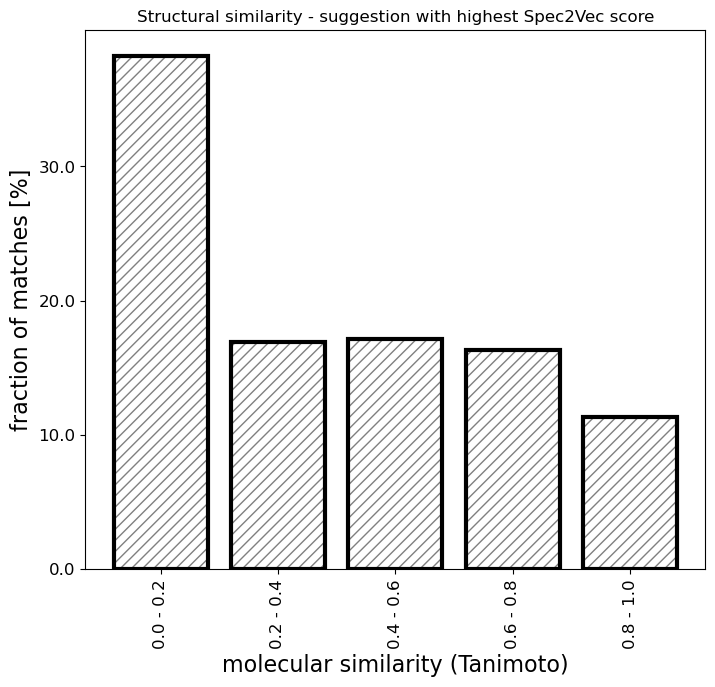

In [36]:
hist, bin_edges = histogram_found_matches(mol_sim_matches, 5, 'argmax', list_cos)

print(hist)
plt.title("Structural similarity - suggestion with highest Spec2Vec score")
plt.savefig("Unknown_compound_matching_annotated_s2v_highest_score.pdf", bbox_inches='tight')

[ 63  95 111 128 105]


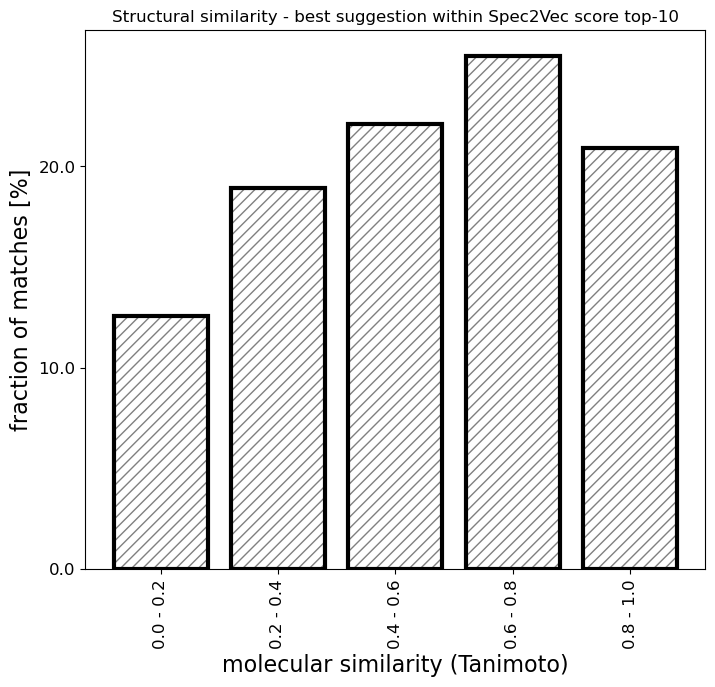

In [37]:
hist, bin_edges = histogram_found_matches(mol_sim_matches, 5, 'ideal_pick', list_cos)

print(hist)
plt.title("Structural similarity - best suggestion within Spec2Vec score top-10")
plt.savefig("Unknown_compound_matching_annotated_s2v_ideal_pick.pdf", bbox_inches='tight')
plt.savefig("Unknown_compound_matching_annotated_s2v_ideal_pick.png", bbox_inches='tight')

## Inspect some suggestions in detail

In [38]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
# IPythonConsole.ipython_useSVG=True

In [39]:
def save_molecule_as(filename, molecules, size=(400,400)):
    img = Draw.MolsToGridImage(molecules, molsPerRow=4, subImgSize=size)
    with open(filename, 'w') as f:
        f.write(img.data)

def save_img_as(filename, img):
    with open(filename, 'w') as f:
        f.write(img.data)


 ---------- Query molecule ----------
[H]OC1=C([H])C([H])=C(O[H])C(=C1[H])C([H])([H])C(=O)O[H]


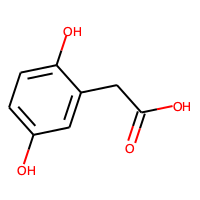

In [40]:
ID = 80  # query number
print("\n ---------- Query molecule ----------")
print(documents_query[ID]._obj.get("smiles"))
#print(documents_query[ID]._obj.get("inchikey"))

mol = Chem.MolFromSmiles(documents_query[ID]._obj.get("smiles"))
img = Draw.MolsToGridImage([mol], molsPerRow=1, subImgSize=(200, 200))
# save_img_as("molecule_query_{}.png".format(ID), img)
img


 ---------- Suggested molecules ----------
[H]OC1=C([H])C([H])=C(C([H])=C1[H])C([H])(O[H])C(=O)O[H]
CCOC(=O)C(O)c(c1)ccc(O)c1
[H]OC(=O)C([H])(O[H])C1=C([H])C([H])=C(O[H])C(OC([H])([H])[H])=C1[H]
[H]OC=1C([H])=C(O[H])C([H])=C(C([H])=C([H])C2=C([H])C([H])=C(O[H])C(O[H])=C2[H])C1[H]
[H]OC([H])([H])C(=O)C1(O[H])C([H])([H])C([H])([H])C2([H])C3([H])C([H])([H])C([H])([H])C4=C([H])C(=O)C([H])([H])C([H])([H])C4(C([H])([H])[H])C3([H])C([H])([H])C([H])([H])C21C([H])([H])[H]
[H]OC=1C([H])=C(O[H])C2=C(OC([H])(C3=C([H])C([H])=C(O[H])C(O[H])=C3[H])C([H])(O[H])C2=O)C1[H]
[H]OC=1C([H])=C(O[H])C([H])=C(C([H])=C([H])C2=C([H])C([H])=C(O[H])C(O[H])=C2[H])C1[H]
[H]OC(=O)C1=C(O[H])C(=NC([H])=C1C([H])([H])O[H])C([H])([H])[H]
COc(c1)c(O)ccc1C(O)C(O)=O
[H]OC=1C([H])=C(O[H])C([H])=C(O[H])C1[H]


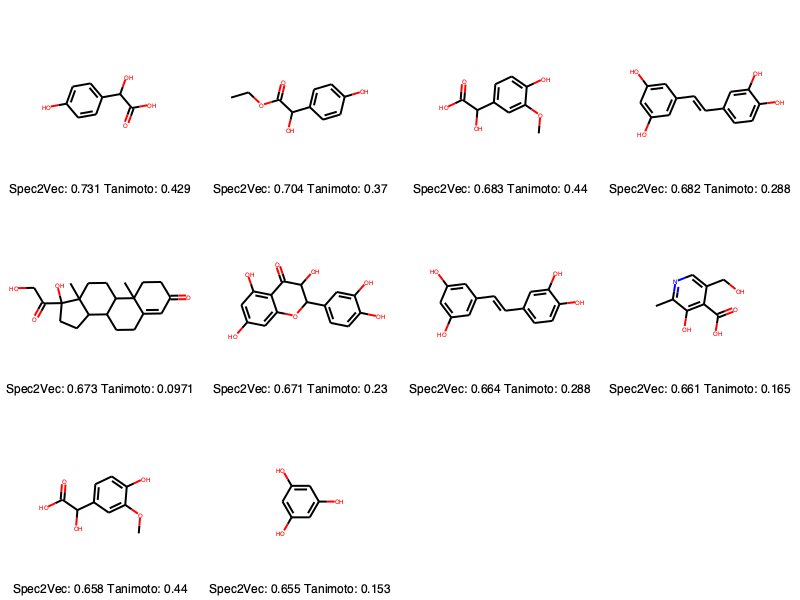

In [41]:
threshold = 0.3
top_10_idx = found_matches[ID][found_matches[ID]['s2v_score'] > threshold].sort_values(by=["s2v_score"], ascending=False).index.tolist()[:10]

scores_sorted = found_matches[ID].sort_values(by=["s2v_score"], ascending=False)["s2v_score"].values
molecules = []
s2v_tanimoto_scores = []
print("\n ---------- Suggested molecules ----------")
for i, idx in enumerate(top_10_idx):
    
    molecules.append(Chem.MolFromSmiles(documents_library[idx]._obj.get("smiles")))  
    s2v_tanimoto_scores.append((scores_sorted[i], mol_sim_matches[ID][0][i]))
    print(documents_library[idx]._obj.get("smiles"))
    #print(documents_library[idx]._obj.get("inchikey"))
    
img = Draw.MolsToGridImage([x for x in molecules if x is not None], molsPerRow=4, subImgSize=(200, 200),
                             legends=["Spec2Vec: {:.3} Tanimoto: {:.3}".format(x[0], x[1]) for x in s2v_tanimoto_scores])
    
# save_img_as("found_molecules_query_{}.png".format(ID), img)
img


 ---------- Query molecule ----------
OC(=O)C(C(O)=O)c(c1)cccc1


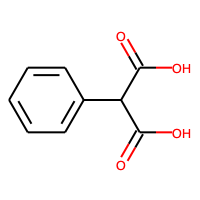

In [42]:
ID = 310  # query number - max length 324, changed for a suitable one
print("\n ---------- Query molecule ----------")
print(documents_query[ID]._obj.get("smiles"))
#print(documents_query[ID]._obj.get("inchikey"))

mol = Chem.MolFromSmiles(documents_query[ID]._obj.get("smiles"))
img = Draw.MolsToGridImage([mol], molsPerRow=1, subImgSize=(200, 200))
# save_img_as("molecule_query_{}.png".format(ID), img)
img


 ---------- Suggested molecules ----------
Cc(c1)cc(cc1)C(O)=O
OC(=O)Cc(c1)cccc1
OC(=O)c(c1)c(C)ccc1
Cc(c1)ccc(c1)C(O)=O
[2H]C(C)(C)OC(=O)c(c1)c(C)ccc1
OCC(C(O)=O)c(c1)cccc1
Cc(c1)ccc(c1)C(O)=O
CC(C)OC(=O)c(c1)c(C)ccc1
CC(C)COC(=O)Cc(c1)cccc1
CC(C)COC(=O)c(c1)c(C)ccc1


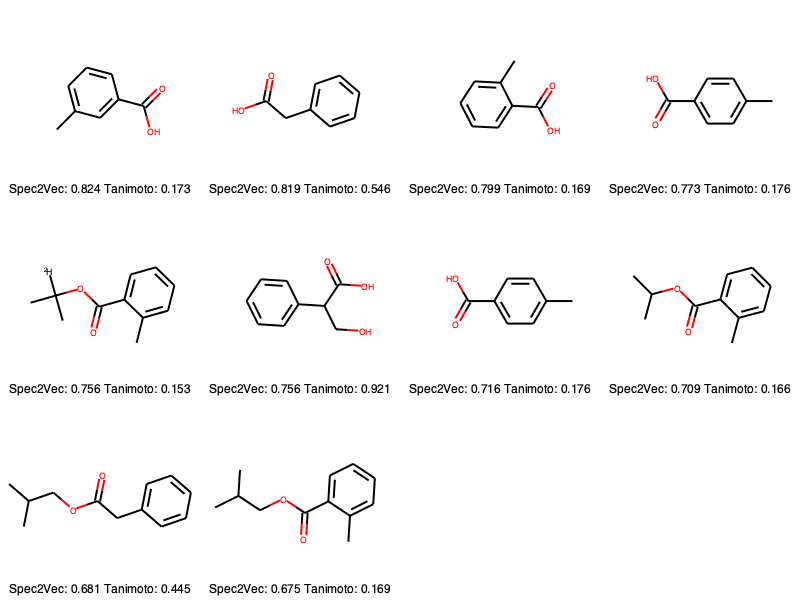

In [43]:
threshold = 0.3
top_10_idx = found_matches[ID][found_matches[ID]['s2v_score'] > threshold].sort_values(by=["s2v_score"], ascending=False).index.tolist()[:10]

scores_sorted = found_matches[ID].sort_values(by=["s2v_score"], ascending=False)["s2v_score"].values
molecules = []
s2v_tanimoto_scores = []
print("\n ---------- Suggested molecules ----------")
for i, idx in enumerate(top_10_idx):
    
    molecules.append(Chem.MolFromSmiles(documents_library[idx]._obj.get("smiles")))  
    s2v_tanimoto_scores.append((scores_sorted[i], mol_sim_matches[ID][0][i]))
    print(documents_library[idx]._obj.get("smiles"))
    #print(documents_library[idx]._obj.get("inchikey"))
    
img = Draw.MolsToGridImage([x for x in molecules if x is not None], molsPerRow=4, subImgSize=(200, 200),
                             legends=["Spec2Vec: {:.3} Tanimoto: {:.3}".format(x[0], x[1]) for x in s2v_tanimoto_scores])
    
# save_img_as("found_molecules_query_{}.png".format(ID), img)
img


 ---------- Query molecule ----------
CCc(c1)c(N)ccc1


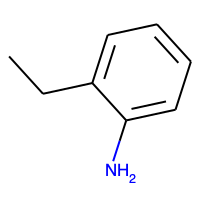

In [44]:
ID = 320  # query number - max length 324, changed for a suitable one
print("\n ---------- Query molecule ----------")
print(documents_query[ID]._obj.get("smiles"))
#print(documents_query[ID]._obj.get("inchikey"))

mol = Chem.MolFromSmiles(documents_query[ID]._obj.get("smiles"))
img = Draw.MolsToGridImage([mol], molsPerRow=1, subImgSize=(200, 200))
# save_img_as("molecule_query_{}.png".format(ID), img)
img


 ---------- Suggested molecules ----------
CCc(c1)ccc(N)c1
CCc(c1)cc(N)cc1
CCNc(c1)cccc1
CCc(c1)c(C)ccn1
CCc(c1)cnc(C)c1
Cc(c1)c(C)c(N)cc1
CCNc(c1)cccc1
CCc(c1)cnc(C)c1
Cc(c1)c(C)c(N)cc1
CN(C)c(c1)cccc1


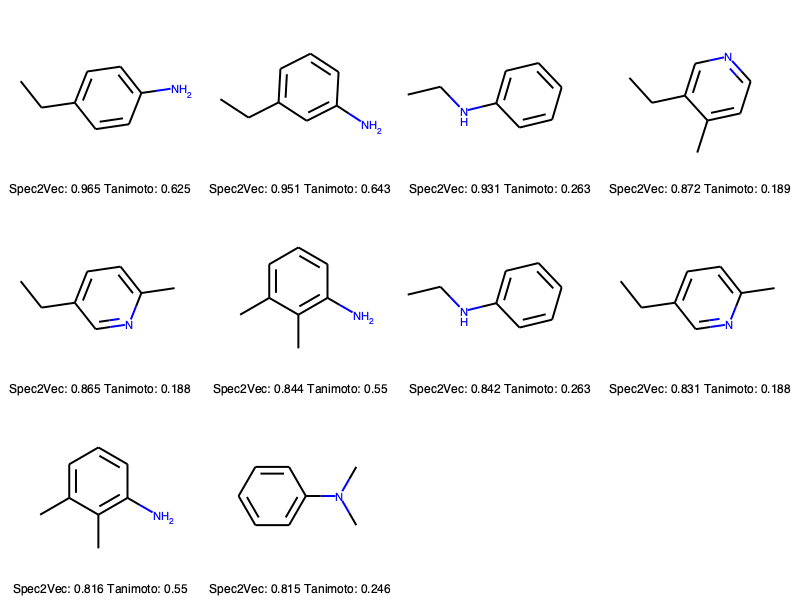

In [45]:
threshold = 0.3
top_10_idx = found_matches[ID][found_matches[ID]['s2v_score'] > threshold].sort_values(by=["s2v_score"], ascending=False).index.tolist()[:10]

scores_sorted = found_matches[ID].sort_values(by=["s2v_score"], ascending=False)["s2v_score"].values
molecules = []
s2v_tanimoto_scores = []
print("\n ---------- Suggested molecules ----------")
for i, idx in enumerate(top_10_idx):
    
    molecules.append(Chem.MolFromSmiles(documents_library[idx]._obj.get("smiles")))  
    s2v_tanimoto_scores.append((scores_sorted[i], mol_sim_matches[ID][0][i]))
    print(documents_library[idx]._obj.get("smiles"))
    #print(documents_library[idx]._obj.get("inchikey"))
    
img = Draw.MolsToGridImage([x for x in molecules if x is not None], molsPerRow=4, subImgSize=(200, 200),
                             legends=["Spec2Vec: {:.3} Tanimoto: {:.3}".format(x[0], x[1]) for x in s2v_tanimoto_scores])
    
# save_img_as("found_molecules_query_{}.png".format(ID), img)
img


 ---------- Query molecule ----------
CSCc(c(CO)1)c(OC)c(OC)c(OC)c1


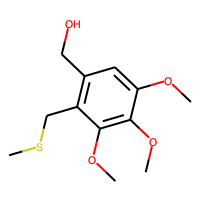

In [46]:
ID = 323  # query number
print("\n ---------- Query molecule ----------")
print(documents_query[ID]._obj.get("smiles"))
#print(documents_query[ID]._obj.get("inchikey"))

mol = Chem.MolFromSmiles(documents_query[ID]._obj.get("smiles"))
img = Draw.MolsToGridImage([mol], molsPerRow=1, subImgSize=(200, 200))
# save_img_as("molecule_query_{}.png".format(ID), img)
img


 ---------- Suggested molecules ----------
COc(c2)ccc(c2)C([H])=C([H])c(c1)nccc1
COC(=O)c(c1)cc(OC)c(OC)c(OC)1
O=Cc(c1)cc(OC)c(OC)c(OC)1
OC(=O)C(C1)C([H])(C(=O)2)C([H])(CC2)C(C)(C)1
[H]OC1=C([H])C([H])=C(C([H])=C1[H])N(=O)=O
CCCCCCCCCCCCCC(OCC(COC(CCCCCCCCCCCCC)=O)OC(=O)CCCCCCCCCCCCC)=O
Nc(n3)c(C)c(n1)c(c(C)3)c(c2)c(ccc2)1
Cc(c2)ccc(c2)Cc(c1)c(C)cnc(C)1
COC(=O)c(c(C)1)c(O)c(C)c(O)c(C)1
O=Cc(c1)cc(OC)c(OC)c(OC)1


RDKit ERROR: [13:00:54] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 7 8 10 11 12 13 14 15
RDKit ERROR: 


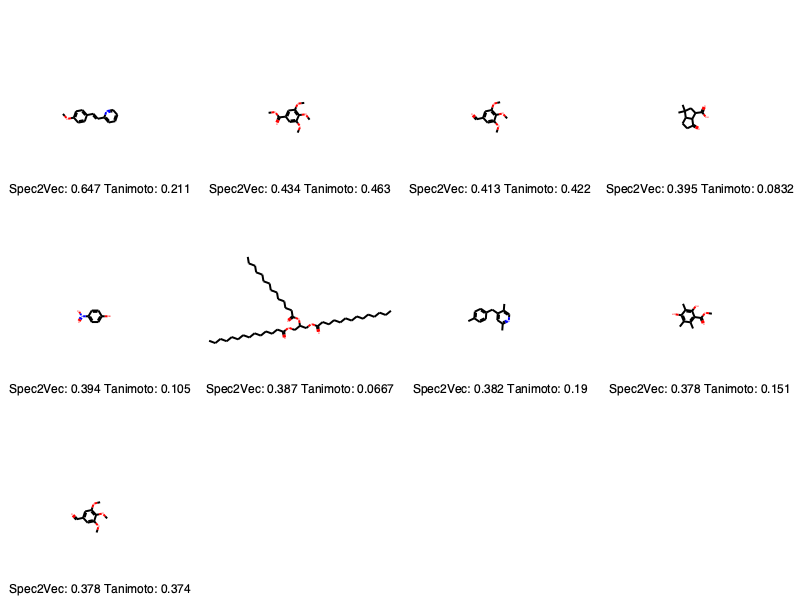

In [47]:
threshold = 0.3
top_10_idx = found_matches[ID][found_matches[ID]['s2v_score'] > threshold].sort_values(by=["s2v_score"], ascending=False).index.tolist()[:10]

scores_sorted = found_matches[ID].sort_values(by=["s2v_score"], ascending=False)["s2v_score"].values
molecules = []
s2v_tanimoto_scores = []
print("\n ---------- Suggested molecules ----------")
for i, idx in enumerate(top_10_idx):
    
    molecules.append(Chem.MolFromSmiles(documents_library[idx]._obj.get("smiles")))  
    s2v_tanimoto_scores.append((scores_sorted[i], mol_sim_matches[ID][0][i]))
    print(documents_library[idx]._obj.get("smiles"))
    #print(documents_library[idx]._obj.get("inchikey"))
    
img = Draw.MolsToGridImage([x for x in molecules if x is not None], molsPerRow=4, subImgSize=(200, 200),
                             legends=["Spec2Vec: {:.3} Tanimoto: {:.3}".format(x[0], x[1]) for x in s2v_tanimoto_scores])
    
# save_img_as("found_molecules_query_{}.png".format(ID), img)
img


 ---------- Query molecule ----------
CSCc(c(CO)1)c(OC)c(OC)c(OC)c1


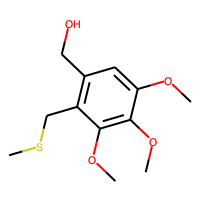

In [48]:
ID = 323 # query number
print("\n ---------- Query molecule ----------")
print(documents_query[ID]._obj.get("smiles"))
#print(documents_query[ID]._obj.get("inchikey"))

mol = Chem.MolFromSmiles(documents_query[ID]._obj.get("smiles"))
img = Draw.MolsToGridImage([mol], molsPerRow=1, subImgSize=(200, 200))
# save_img_as("molecule_query_{}.png".format(ID), img)
img


 ---------- Suggested molecules ----------
COc(c2)ccc(c2)C([H])=C([H])c(c1)nccc1
COC(=O)c(c1)cc(OC)c(OC)c(OC)1
O=Cc(c1)cc(OC)c(OC)c(OC)1
OC(=O)C(C1)C([H])(C(=O)2)C([H])(CC2)C(C)(C)1
[H]OC1=C([H])C([H])=C(C([H])=C1[H])N(=O)=O
CCCCCCCCCCCCCC(OCC(COC(CCCCCCCCCCCCC)=O)OC(=O)CCCCCCCCCCCCC)=O
Nc(n3)c(C)c(n1)c(c(C)3)c(c2)c(ccc2)1
Cc(c2)ccc(c2)Cc(c1)c(C)cnc(C)1
COC(=O)c(c(C)1)c(O)c(C)c(O)c(C)1
O=Cc(c1)cc(OC)c(OC)c(OC)1


RDKit ERROR: [13:00:54] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 7 8 10 11 12 13 14 15
RDKit ERROR: 


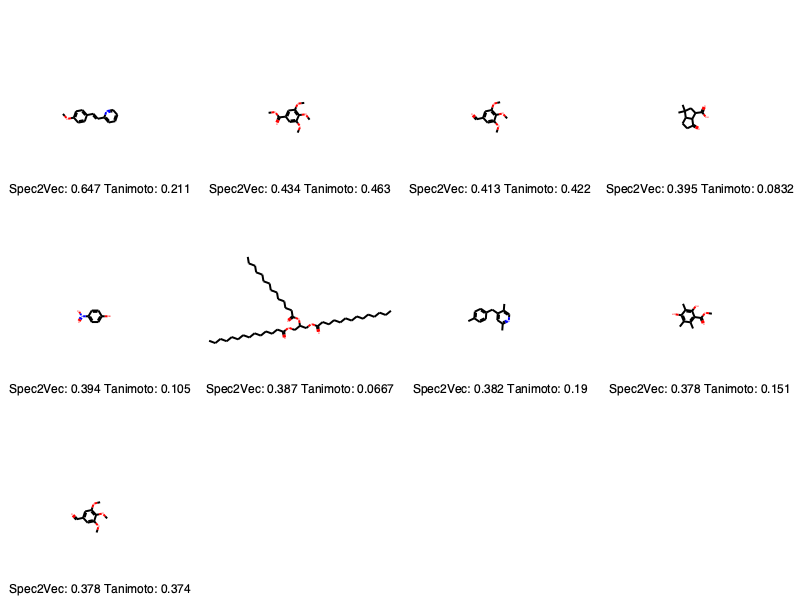

In [49]:
top_10_idx = found_matches[ID][found_matches[ID]['s2v_score'] > threshold].sort_values(by=["s2v_score"], ascending=False).index.tolist()[:10]

scores_sorted = found_matches[ID].sort_values(by=["s2v_score"], ascending=False)["s2v_score"].values
molecules = []
s2v_tanimoto_scores = []
print("\n ---------- Suggested molecules ----------")
for i, idx in enumerate(top_10_idx):
    
    molecules.append(Chem.MolFromSmiles(documents_library[idx]._obj.get("smiles")))  
    s2v_tanimoto_scores.append((scores_sorted[i], mol_sim_matches[ID][0][i]))
    print(documents_library[idx]._obj.get("smiles"))
    #print(documents_library[idx]._obj.get("inchikey"))
    
img = Draw.MolsToGridImage([x for x in molecules if x is not None], molsPerRow=4, subImgSize=(200, 200),
                             legends=["Spec2Vec: {:.3} Tanimoto: {:.3}".format(x[0], x[1]) for x in s2v_tanimoto_scores])
    
# save_img_as("found_molecules_query_{}.png".format(ID), img)
img


 ---------- Query molecule ----------
CSCc(c(CO)1)c(OC)c(OC)c(OC)c1


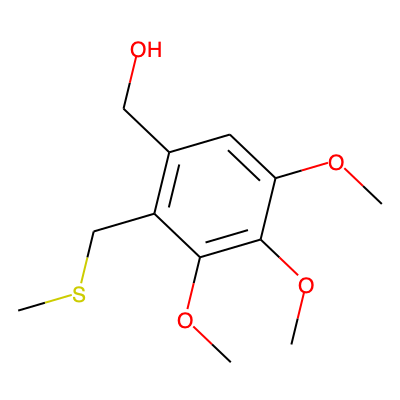

In [50]:
ID = 323 #940 # query number
print("\n ---------- Query molecule ----------")
print(documents_query[ID]._obj.get("smiles"))
#print(documents_query[ID]._obj.get("inchikey"))

mol = Chem.MolFromSmiles(documents_query[ID]._obj.get("smiles"))
img = Draw.MolsToGridImage([mol], molsPerRow=1, subImgSize=(400, 400))
# save_img_as("molecule_query_{}.png".format(ID), img)
img


 ---------- Suggested molecules ----------
COc(c2)ccc(c2)C([H])=C([H])c(c1)nccc1
COC(=O)c(c1)cc(OC)c(OC)c(OC)1
O=Cc(c1)cc(OC)c(OC)c(OC)1
OC(=O)C(C1)C([H])(C(=O)2)C([H])(CC2)C(C)(C)1
[H]OC1=C([H])C([H])=C(C([H])=C1[H])N(=O)=O
CCCCCCCCCCCCCC(OCC(COC(CCCCCCCCCCCCC)=O)OC(=O)CCCCCCCCCCCCC)=O
Nc(n3)c(C)c(n1)c(c(C)3)c(c2)c(ccc2)1
Cc(c2)ccc(c2)Cc(c1)c(C)cnc(C)1
COC(=O)c(c(C)1)c(O)c(C)c(O)c(C)1
O=Cc(c1)cc(OC)c(OC)c(OC)1


RDKit ERROR: [13:00:54] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 7 8 10 11 12 13 14 15
RDKit ERROR: 


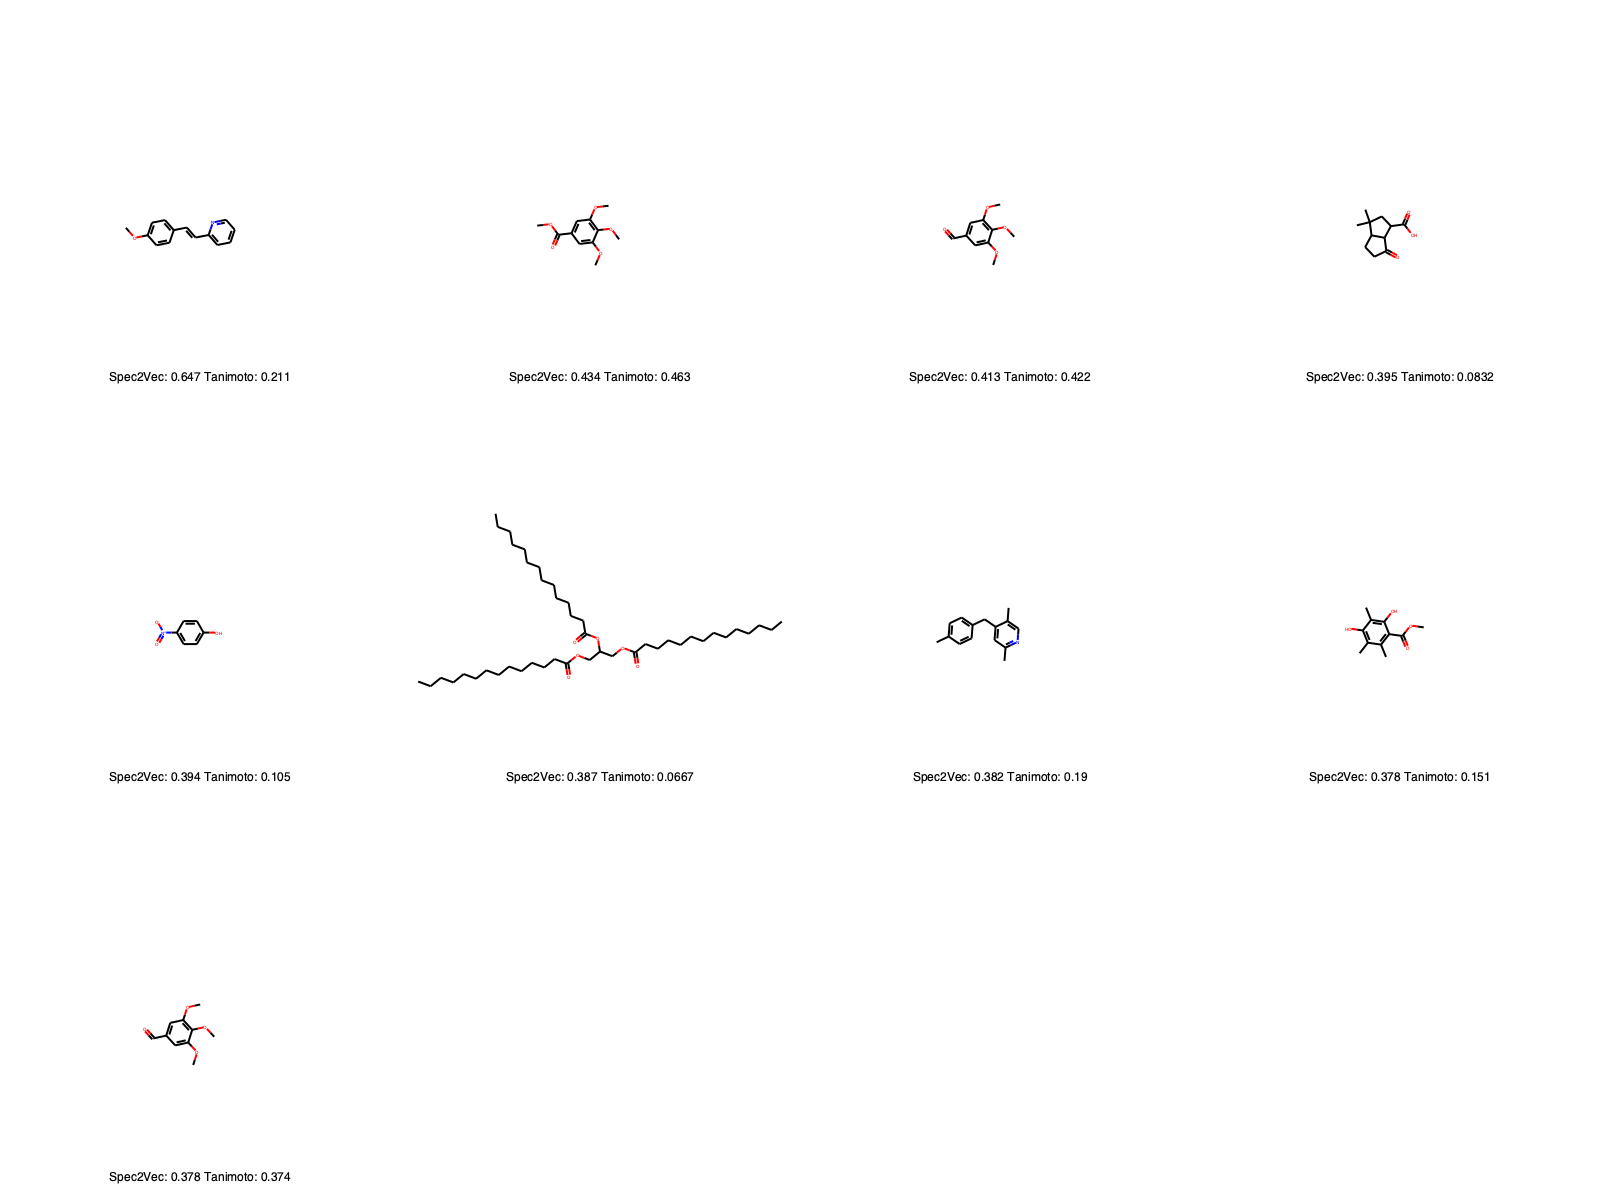

In [51]:
threshold = 0.3
top_10_idx = found_matches[ID][found_matches[ID]['s2v_score'] > threshold].sort_values(by=["s2v_score"], ascending=False).index.tolist()[:10]

scores_sorted = found_matches[ID].sort_values(by=["s2v_score"], ascending=False)["s2v_score"].values
molecules = []
s2v_tanimoto_scores = []
print("\n ---------- Suggested molecules ----------")
for i, idx in enumerate(top_10_idx):
    
    molecules.append(Chem.MolFromSmiles(documents_library[idx]._obj.get("smiles")))  
    s2v_tanimoto_scores.append((scores_sorted[i], mol_sim_matches[ID][0][i]))
    print(documents_library[idx]._obj.get("smiles"))
    #print(documents_library[idx]._obj.get("inchikey"))
    
img = Draw.MolsToGridImage([x for x in molecules if x is not None], molsPerRow=4, subImgSize=(400, 400),
                             legends=["Spec2Vec: {:.3} Tanimoto: {:.3}".format(x[0], x[1]) for x in s2v_tanimoto_scores])
    
# save_img_as("found_molecules_query_{}.png".format(ID), img)
img


 ---------- Query molecule ----------
[H]OC1=C([H])C([H])=C(O[H])C(=C1[H])C([H])([H])C(=O)O[H]


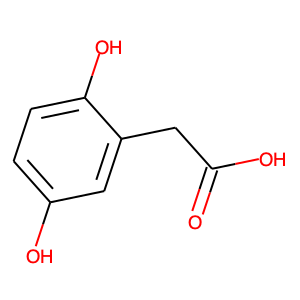

In [52]:
ID = 80 # query number
print("\n ---------- Query molecule ----------")
print(documents_query[ID]._obj.get("smiles"))
#print(documents_query[ID]._obj.get("inchikey"))

mol = Chem.MolFromSmiles(documents_query[ID]._obj.get("smiles"))
img = Draw.MolsToGridImage([mol], molsPerRow=1, subImgSize=(300, 300))
# save_img_as("molecule_query_{}.png".format(ID), img)
img


 ---------- Suggested molecules ----------
[H]OC1=C([H])C([H])=C(C([H])=C1[H])C([H])(O[H])C(=O)O[H]
CCOC(=O)C(O)c(c1)ccc(O)c1
[H]OC(=O)C([H])(O[H])C1=C([H])C([H])=C(O[H])C(OC([H])([H])[H])=C1[H]
[H]OC=1C([H])=C(O[H])C([H])=C(C([H])=C([H])C2=C([H])C([H])=C(O[H])C(O[H])=C2[H])C1[H]
[H]OC([H])([H])C(=O)C1(O[H])C([H])([H])C([H])([H])C2([H])C3([H])C([H])([H])C([H])([H])C4=C([H])C(=O)C([H])([H])C([H])([H])C4(C([H])([H])[H])C3([H])C([H])([H])C([H])([H])C21C([H])([H])[H]
[H]OC=1C([H])=C(O[H])C2=C(OC([H])(C3=C([H])C([H])=C(O[H])C(O[H])=C3[H])C([H])(O[H])C2=O)C1[H]
[H]OC=1C([H])=C(O[H])C([H])=C(C([H])=C([H])C2=C([H])C([H])=C(O[H])C(O[H])=C2[H])C1[H]
[H]OC(=O)C1=C(O[H])C(=NC([H])=C1C([H])([H])O[H])C([H])([H])[H]
COc(c1)c(O)ccc1C(O)C(O)=O
[H]OC=1C([H])=C(O[H])C([H])=C(O[H])C1[H]


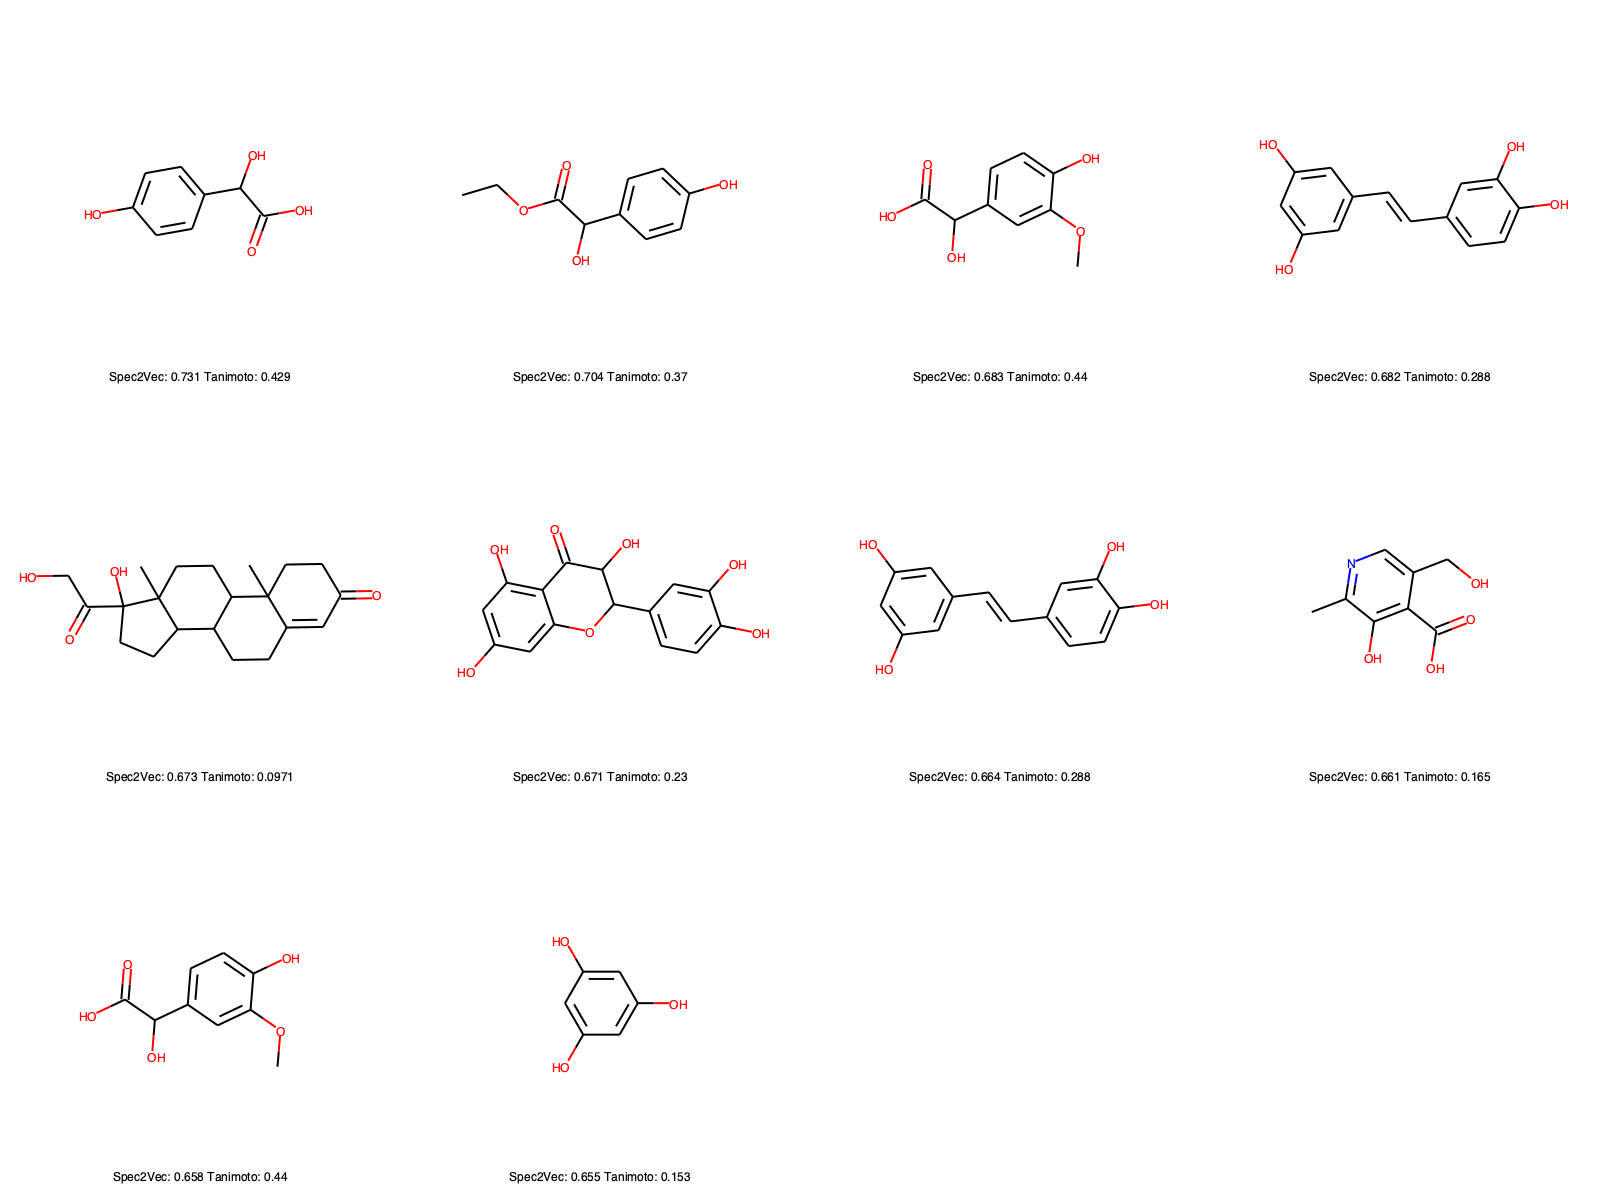

In [53]:
top_10_idx = found_matches[ID][found_matches[ID]['s2v_score'] > threshold].sort_values(by=["s2v_score"], ascending=False).index.tolist()[:10]

scores_sorted = found_matches[ID].sort_values(by=["s2v_score"], ascending=False)["s2v_score"].values
molecules = []
s2v_tanimoto_scores = []
print("\n ---------- Suggested molecules ----------")
for i, idx in enumerate(top_10_idx):
    
    molecules.append(Chem.MolFromSmiles(documents_library[idx]._obj.get("smiles")))  
    s2v_tanimoto_scores.append((scores_sorted[i], mol_sim_matches[ID][0][i]))
    print(documents_library[idx]._obj.get("smiles"))
    #print(documents_library[idx]._obj.get("inchikey"))
    
img = Draw.MolsToGridImage([x for x in molecules if x is not None], molsPerRow=4, subImgSize=(400, 400),
                             legends=["Spec2Vec: {:.3} Tanimoto: {:.3}".format(x[0], x[1]) for x in s2v_tanimoto_scores])
    
# save_img_as("found_molecules_query_{}.png".format(ID), img)
img


 ---------- Query molecule ----------
COc(c3)ccc(c3)C(O1)=C(O)C(=O)c(c2)c(cc(OC)c(OC)2)1


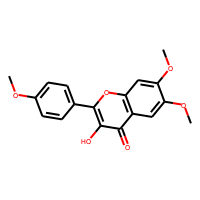

In [54]:
ID = 0  # query number
print("\n ---------- Query molecule ----------")
print(documents_query[ID]._obj.get("smiles"))
#print(documents_query[ID]._obj.get("inchikey"))

mol = Chem.MolFromSmiles(documents_query[ID]._obj.get("smiles"))
img = Draw.MolsToGridImage([mol], molsPerRow=1, subImgSize=(200, 200))
# save_img_as("molecule_query_{}.png".format(ID), img)
img


 ---------- Suggested molecules ----------
COc(c5)c(OC)c(O4)c(c5)C([H])(O1)C([H])(C4)c(c2)c(cc(O3)c(OC3)2)1
COc(c1)ccc(c1)C(=O)Cl
COc(c1)c(ccc1)C(C)=O
COc(c1)ccc(c1)C(C)=O
CCOC(OCC)c(c1)cccc1
COc(c1)c(ccc1)C(C)=O
CC(C)c(c1)c(O)cc(C)c1
CCOC(=O)c(c1)ccc(OC)c1
COc(c1)ccc(c1)C(=O)OCC(C)C
c(c1)ccc(c1)[Si](C)(C)C


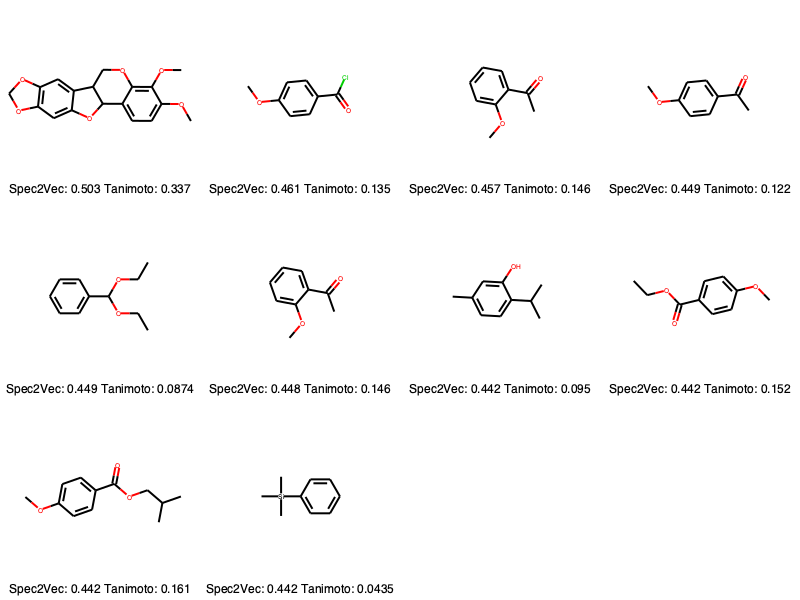

In [55]:
threshold = 0.3
top_10_idx = found_matches[ID][found_matches[ID]['s2v_score'] > threshold].sort_values(by=["s2v_score"], ascending=False).index.tolist()[:10]

scores_sorted = found_matches[ID].sort_values(by=["s2v_score"], ascending=False)["s2v_score"].values
molecules = []
s2v_tanimoto_scores = []
print("\n ---------- Suggested molecules ----------")
for i, idx in enumerate(top_10_idx):
    
    molecules.append(Chem.MolFromSmiles(documents_library[idx]._obj.get("smiles")))  
    s2v_tanimoto_scores.append((scores_sorted[i], mol_sim_matches[ID][0][i]))
    print(documents_library[idx]._obj.get("smiles"))
    #print(documents_library[idx]._obj.get("inchikey"))
    
img = Draw.MolsToGridImage([x for x in molecules if x is not None], molsPerRow=4, subImgSize=(200, 200),
                             legends=["Spec2Vec: {:.3} Tanimoto: {:.3}".format(x[0], x[1]) for x in s2v_tanimoto_scores])
    
# save_img_as("found_molecules_query_{}.png".format(ID), img)
img

### Compare number of words vs match with structural similarity

In [56]:
n_words = []
for doc in documents_query:
    n_words.append(len(doc.words))

In [57]:
mol_sim_matches[323], len(n_words)

(array([[0.21052632, 0.4633758 , 0.42160279, 0.08321965, 0.1047619 ,
         0.06666667, 0.19010669, 0.15119363, 0.37400531, 0.42160279]]),
 502)

Text(0, 0.5, 'structural similarity')

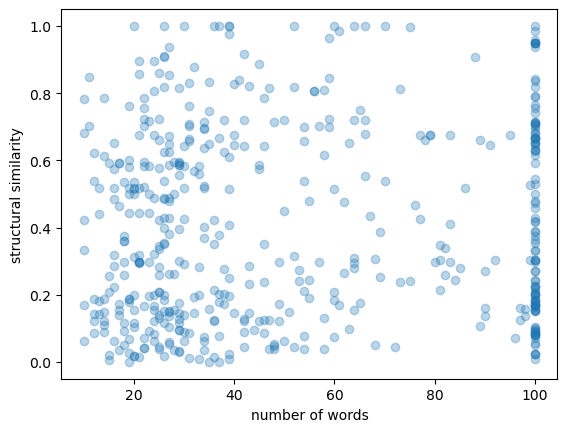

In [58]:
plt.scatter(np.asarray(n_words), np.asarray([x[0][0] for x in mol_sim_matches]), alpha=0.3)
plt.xlabel("number of words")
plt.ylabel("structural similarity")

# Try "actual" library matching (where one doesn't know if a compound is part of the library)
## How could one distinguish an actual match with the itendical compound from a match to a highly related compound?
* Cosine score should be higher for perfect matches

In [59]:
cosine_thres = 0.9

suggested_matches = []
for i, matches in enumerate(found_matches):
    matches_sorted = matches.sort_values(by=["s2v_score"], ascending=False)[:10]
    actual_matches = np.where((matches_sorted["cosine_score"] > cosine_thres))[0]
    if len(actual_matches) > 0:
        suggested_matches.append((i, actual_matches))

In [60]:
len(suggested_matches)

253

In [61]:
suggested_matches

[(0, array([0])),
 (2, array([0, 1, 2, 3, 4, 5, 6, 7, 8])),
 (3, array([1, 2])),
 (4, array([0, 1, 2, 3, 4])),
 (5, array([0])),
 (7, array([0, 1, 2, 3])),
 (8, array([0, 1, 3, 4, 6])),
 (9, array([0, 2])),
 (10, array([0, 5, 6, 7, 8])),
 (12, array([0, 1, 2, 3, 4, 5, 6, 7, 8])),
 (13, array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])),
 (15, array([1])),
 (16, array([0])),
 (17, array([0, 1, 2, 3, 4, 5, 6, 7])),
 (18, array([0, 1, 2, 3, 4, 5, 6, 7])),
 (19, array([0, 1, 2, 3, 4, 7])),
 (20, array([0, 1, 2, 3])),
 (26, array([0, 1])),
 (27, array([0, 1])),
 (28, array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])),
 (29, array([2])),
 (30, array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])),
 (31, array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])),
 (32, array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])),
 (33, array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])),
 (34, array([0, 1, 2, 3, 5, 6, 7, 8])),
 (35, array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])),
 (36, array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])),
 (37, array([0, 1, 3, 4, 5, 7, 8])),
 (38, array([0, 1, 2, 3, 4, 5, 

In [62]:
found_matches[86].sorwt_values(by=["s2v_score"], ascending=False)[:10]

,cosine_score,cosine_matches,s2v_score
4661,0.873268,63,0.711315
4657,0.775007,55,0.700285
4671,0.853927,71,0.678222
4659,0.699758,54,0.667775
4655,0.740208,61,0.664472
7427,0.820001,34,0.662106
5864,0.810620,30,0.654317
1600,0.776946,37,0.631454
8607,0.809855,32,0.627548
3985,0.775070,46,0.620929


In [63]:
print(documents_library[13630]._obj.get("smiles"))
print(documents_query[28]._obj.get("smiles"))

[H]OC(=O)C1([H])C([H])([H])C([H])([H])C([H])(O[H])C([H])([H])C1([H])[H]
NCCCC(O)=O


In [64]:
cosine_thres = 0.5
actual_matches = np.where((matches_sorted["cosine_score"]>cosine_thres))
print(actual_matches)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),)
